## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [6]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from scipy.integrate import simpson
from scipy.integrate import odeint

from const import *
import ldf
import plotting
import method

importlib.reload(plotting)
importlib.reload(ldf)
importlib.reload(method)

<module 'method' from 'c:\\Users\\GUNU\\OneDrive\\바탕 화면\\negative-ion\\method.py'>

./220210/forward/Arc voltage change/0 mm/144V.ldf


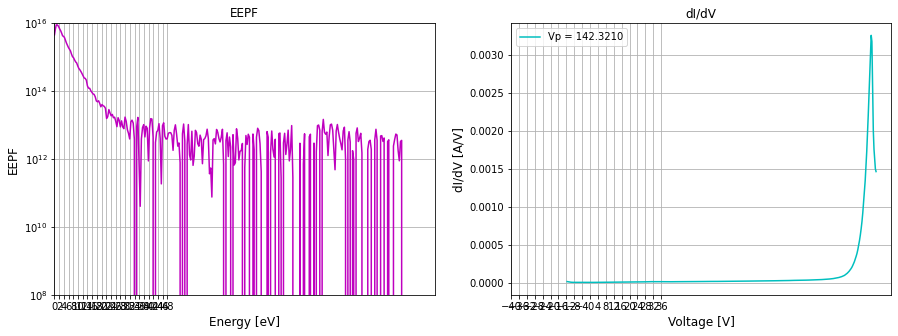

Enter limited energy
ne: 3.798e+16 [m-3]	 Te: 36.004 [eV] 	 V_lim: 150.0
./220210/forward/Arc voltage change/0 mm/40V.ldf


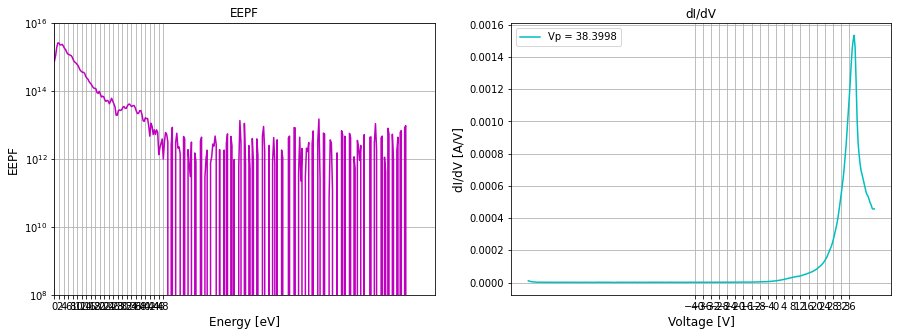

Enter limited energy
ne: 1.837e+16 [m-3]	 Te: 31.119 [eV] 	 V_lim: 150.0
./220210/forward/Arc voltage change/0 mm/88V.ldf


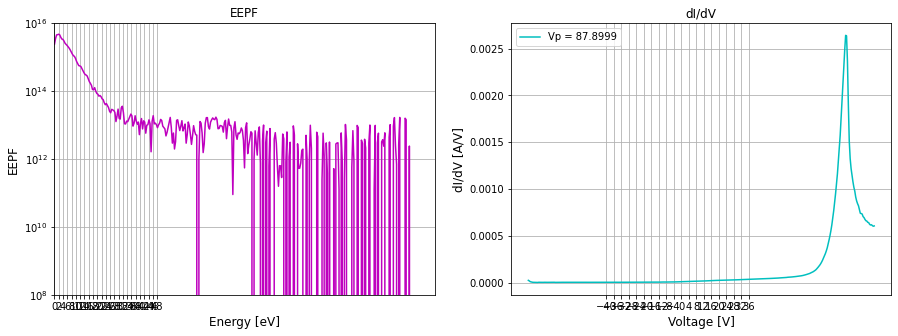

Enter limited energy
ne: 3.100e+16 [m-3]	 Te: 42.781 [eV] 	 V_lim: 150.0


In [7]:
data_iter, data_fit = [], []

workDir = './211221(SF6)/SF6/Radial Scan_20V/'
x_type = 'Distance'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)


    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return=True)
    x = float(file.split('/')[-1][:-4])


    # Calculation x, Vsat, Isat, Vp, eepf, eedf, second_derivative from IV curve
    processor = ldf.processor(IV)
    Vsat, Isat = processor.cal_sat()
    Vp = processor.cal_Vp()
    energy, eepf, eedf = processor.cal_eepf()
    V, IV_second_derivative = processor.cal_second_derivative()


    # Plot EEPF and dIdV to determine energy range 
    plotting.plot_check(energy, eepf, processor.V, processor.dIdV, Vp)


    # Enter energy range for EEDF integration to get ne & Te
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)


    # Calculation ne & Te from EEDF
    ne = processor.cal_ne(V_lim)
    Te = processor.cal_Te(ne, V_lim)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    

    # Start Iterative method
    iter_1 = method.iterative(ne, Te, Vsat, Isat, Vp)
    alpha_iter = iter_1.iteration()
    nm = ne*alpha_iter
    #print("Iteration method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    data_iter.append((Vp, alpha_iter, Te, x, ne, nm))


    # Start Fitting method
    # fit_1 = method.fitting(IV, V, IV_second_derivative)
    # alpha_fit = fit_1.fitting()
    # nm = ne*alpha_fit
    # #print("Fitting method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    # data_fit.append((Vp, alpha_fit, Te, x, ne, nm))


# Plot results
df_iter = pd.DataFrame(data_iter, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
plotting.plot_default(df_iter['x'], df_iter['Te'], df_iter['Vp'], df_iter['alpha'], df_iter['ne'], x_type=x_type, save=True)
plotting.plot_density(df_iter['x'], df_iter['ne'], df_iter['nm'], x_type=x_type, save=True)
df_iter.to_csv('result.csv')
# df_fit = pd.DataFrame(data_fit, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
# plotting.plot_default(df_fit['x'], df_fit['Te'], df_fit['Vp'], df_fit['alpha'], df_fit['ne'])
# plotting.plot_density(df_fit['x'], df_fit['ne'], df_fit['nm'])

In [14]:
y = 14
x = 9.2

114.84/x/y

0.8916149068322982

In [ ]:
114.84/x/y

In [15]:
x*y

128.79999999999998

In [17]:
y*np.sqrt(114.84/x/y)

13.21955073892946

In [18]:
x*np.sqrt(114.84/x/y)

8.687133342725074

In [3]:
4.2*200*45/10

3780.0